In [20]:
from datetime import datetime

import incense
import matplotlib.pyplot as plt
import numpy as np
from incense import ExperimentLoader


In [21]:
loader = ExperimentLoader(db_name="sacred")


In [22]:
def parse_params(s: str) -> dict:
    """Parse a string of space-separated key=value pairs into a dictionary.

    Example:
        >>> parse_params("a=10 b=1e-4 c=bab | some comment # whatever else")
        {'a': 10, 'b': 0.0001, 'c': 'bab'}
    """
    result = {}
    pairs = s.strip().split()

    for pair in pairs:
        try:
            key, value = pair.split("=")
        except Exception:
            continue
        try:
            value = float(value)
            if value.is_integer():
                value = int(value)
        except ValueError:
            pass
        result[key] = value

    return result


print(parse_params("a=10 b=1e-4 c=bab | some comment # whatever else"))


{'a': 10, 'b': 0.0001, 'c': 'bab'}


In [23]:
from collections import defaultdict
from pprint import pprint

lists = defaultdict(list)
names = ["slope-1"]  # , "fixed-steps"]

for exp in loader.find_all():
    notes = exp.meta["comment"]
    if not any(name in notes for name in names):
        continue

    try:
        params = parse_params(notes)
        step = params["step"]
        w = params.get("w", None)
        if params["k"] == "AR":
            w = 1
        elif params["k"] == "D":
            w = 100
        value = min(exp.metrics["q50"])
        lists[(step, w)].append(value)
    except Exception:
        continue


In [24]:
lists


defaultdict(list,
            {(2, 1): [0.13018903136253357,
              0.1306203305721283,
              0.10940273106098175,
              0.09160500019788742,
              0.13786154985427856,
              0.19172358512878418],
             (2, 2): [0.10395406931638718,
              0.0782899260520935,
              0.1072981134057045,
              0.10699337720870972,
              0.12240411341190338,
              0.1041865199804306],
             (2, 3): [0.11159977316856384,
              0.0545191764831543,
              0.10941210389137268,
              0.1061495766043663,
              0.12332071363925934,
              0.09283207356929779],
             (2, 4): [0.06415454298257828,
              0.0863092690706253,
              0.07990334928035736,
              0.0802159309387207,
              0.11506949365139008,
              0.08946707844734192],
             (2, 5): [0.06210869923233986,
              0.02663031406700611,
              0.06813213229179382,
 

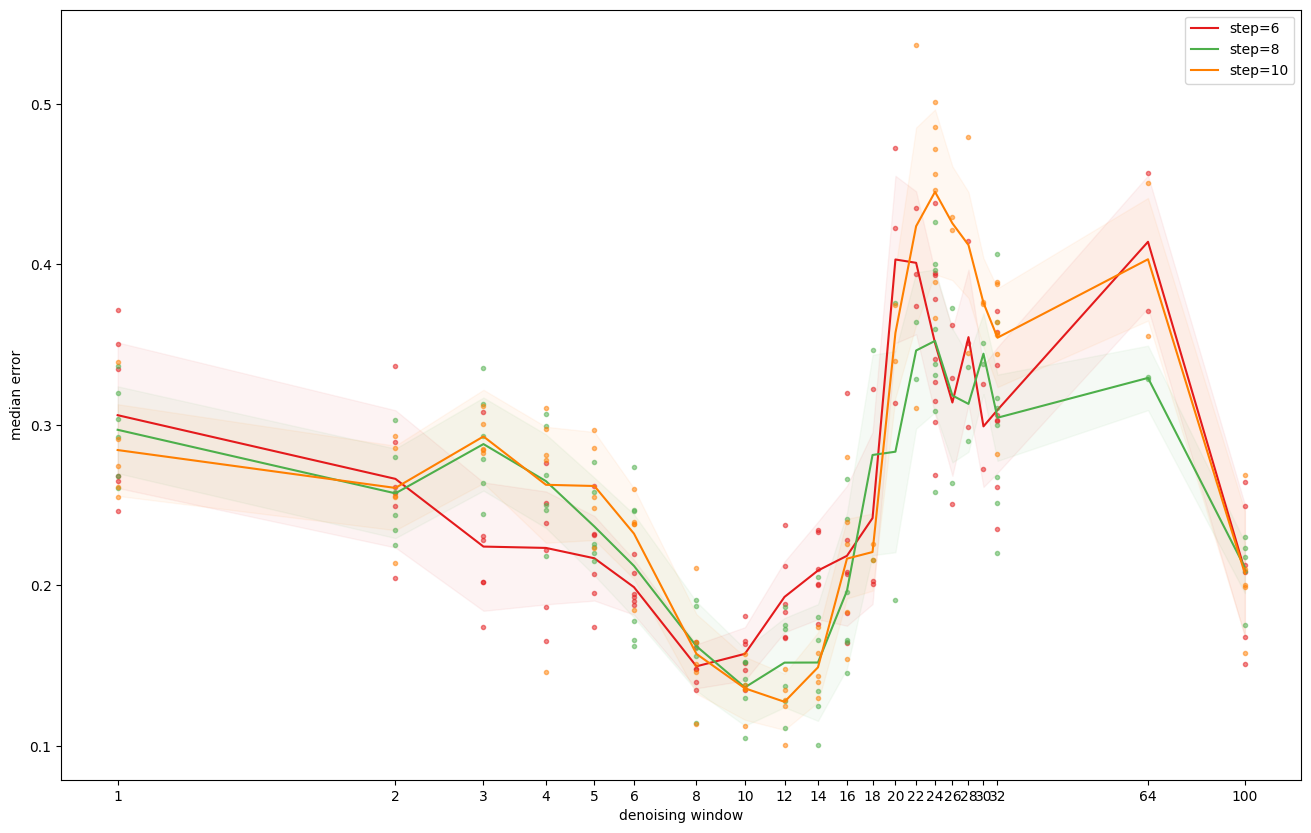

In [45]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 10))
plt.xscale("symlog")
ws = sorted(list(set([w for (step, w) in lists])))
steps = sorted(list(set([step for (step, w) in lists])))
colors = plt.cm.Set1(np.linspace(0.1, 0.9, len(steps)))

steps = [6, 8, 10]

for step, color in zip(steps, colors):
    # Collect and compute statistics for each window size
    means, stds, xs = [], [], []
    for w in ws:
        cur = lists[(step, w)]
        cur = [x for x in cur if x < 0.6]
        if len(cur) > 0:
            means.append(np.mean(cur))
            stds.append(np.std(cur))
            xs.append(w)
            plt.plot([w] * len(cur), cur, "o", ms=3, alpha=0.5, color=color)

    if len(xs) == 0:
        continue

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    # Smooth means and stds with gaussian filter
    from scipy.ndimage import gaussian_filter1d

    means = gaussian_filter1d(means, sigma=0.01)
    stds = gaussian_filter1d(stds, sigma=1.0)
    xs = np.array(xs)

    # Plot mean line and std area
    plt.plot(xs, means, "-", label=f"step={step}", color=color)
    plt.fill_between(xs, means - stds, means + stds, alpha=0.05, color=color)

plt.xticks(ws, [str(w) for w in ws])
plt.xlabel("denoising window")
plt.ylabel("median error")
plt.legend()
plt.show()


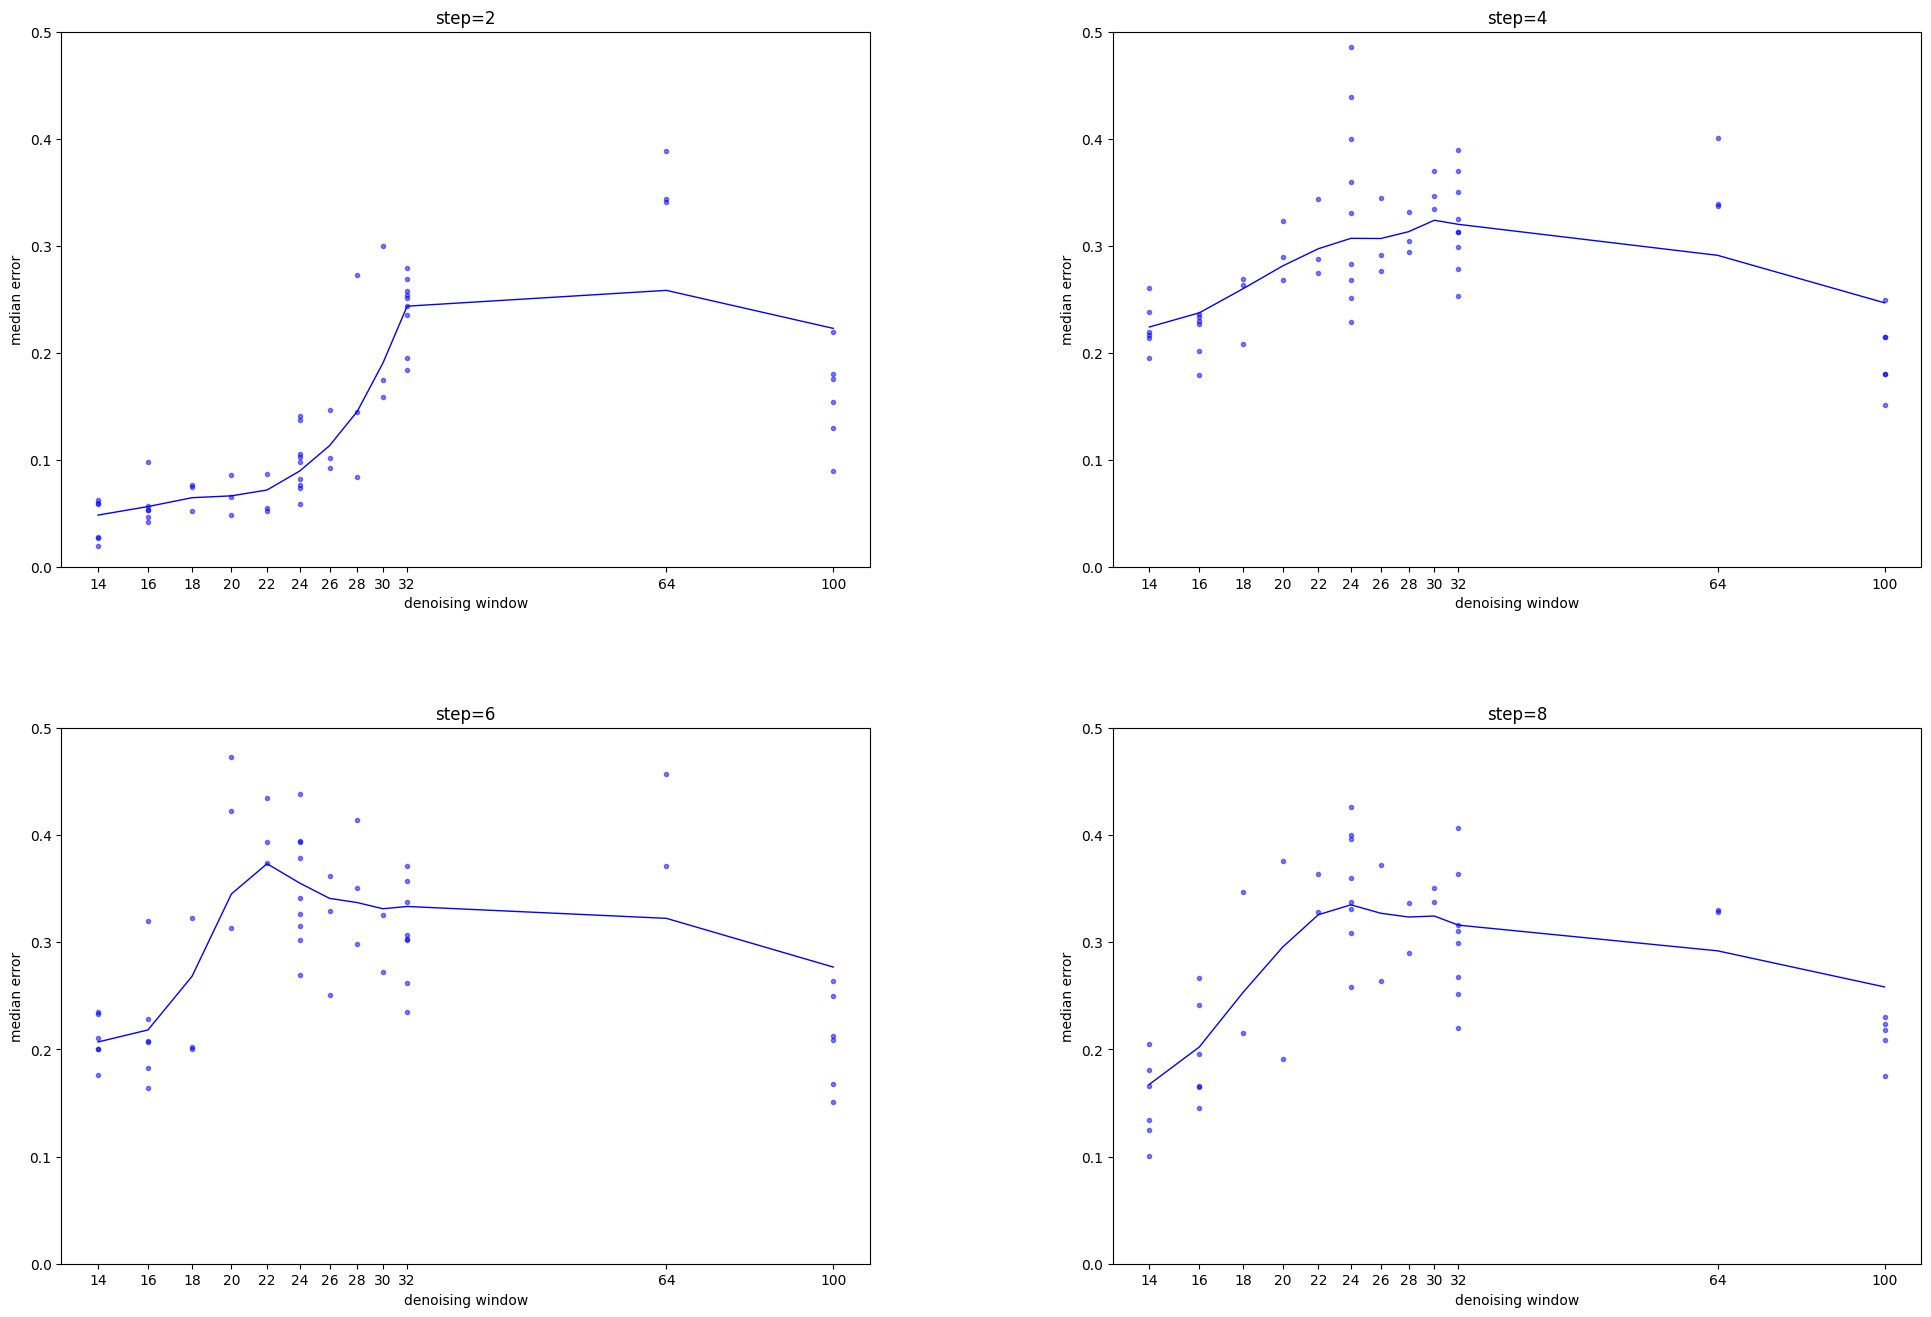

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

fig, axes = plt.subplots(2, 2, figsize=(24, 16))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.flatten()

ws = sorted(list(set([w for (step, w) in lists])))
ws = [x for x in ws if x in range(14, 300)]
steps = sorted(list(set([step for (step, w) in lists])))
colors = plt.cm.Set1(np.linspace(0.3, 0.7, len(steps)))
steps = [2, 4, 6, 8]

for ax, (step, color) in zip(axes, zip(steps, colors)):
    color = "blue"
    ax.set_xscale("symlog")

    # Collect and compute statistics for each window size
    means, stds, xs = [], [], []
    for w in ws:
        cur = lists[(step, w)]
        if len(cur) > 0:
            means.append(np.median(cur))
            stds.append(np.std(cur))
            xs.append(w)
            ax.plot([w] * len(cur), cur, "o", ms=3, alpha=0.5, color=color)

    if len(xs) == 0:
        continue

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    xs = np.array(xs)

    # Smooth means and stds with gaussian filter
    means = gaussian_filter1d(means, sigma=1.0)
    stds = gaussian_filter1d(stds, sigma=1.0)

    # Plot mean line and std area
    ax.plot(xs, means, "-", label=f"step={step}", color=color, lw=1)
    # ax.fill_between(xs, means - stds, means + stds, alpha=0.05, color=color)

    ax.set_xticks(ws)
    ax.set_xticklabels([str(w) for w in ws])
    ax.set_title(f"step={step}")
    ax.set_xlabel("denoising window")
    ax.set_ylabel("median error")
    ax.set_ylim(0.0, 0.5)

plt.show()


/Users/mike/Desktop/gud/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter kernel__length_scale is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/mike/Desktop/gud/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter kernel__length_scale is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/mike/Desktop/gud/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter kernel__length_scale is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


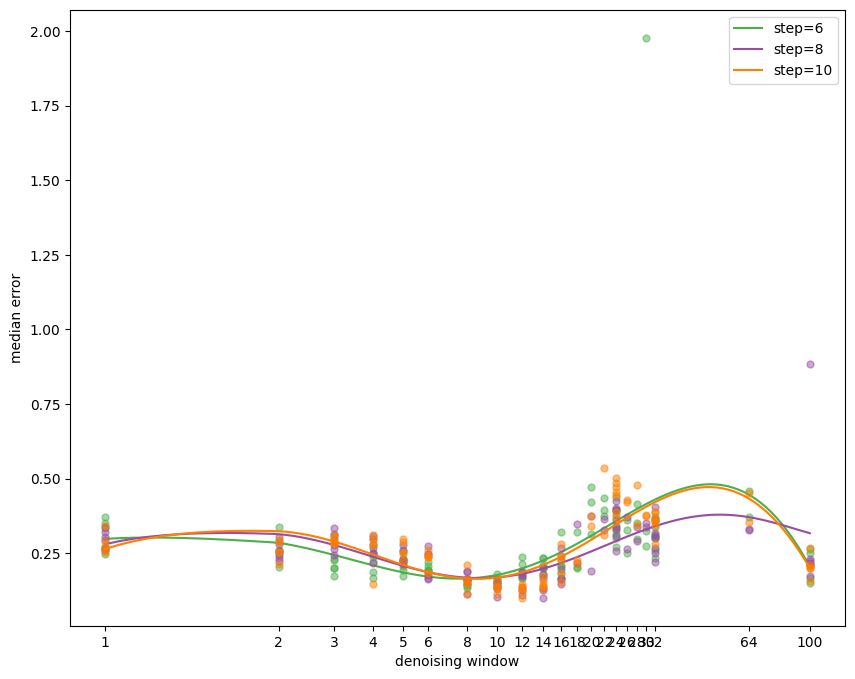

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

plt.figure(figsize=(10, 8))
plt.xscale("symlog")
ws = sorted(list(set([w for (step, w) in lists])))
steps = sorted(list(set([step for (step, w) in lists])))
colors = plt.cm.Set1(np.linspace(0.3, 0.7, len(steps)))
steps = [6, 8, 10]

for step, color in zip(steps, colors):
    # Collect data points for each window size
    points_x, points_y = [], []
    for w in ws:
        cur = lists[(step, w)]
        cur = [x for x in cur if x < 2]
        if len(cur) > 0:
            points_x.extend([np.log1p(w)] * len(cur))
            points_y.extend(cur)
            plt.plot([w] * len(cur), cur, "o", ms=5, alpha=0.5, color=color)

    if len(points_x) == 0:
        continue

    # Convert to arrays and reshape for GP
    X = np.array(points_x).reshape(-1, 1)
    y = np.array(points_y)

    # Define kernel as sum of RBF and WhiteNoise
    l, r = 5.0, 10.0
    kernel = (
        RBF(length_scale=(l * r) ** 0.5, length_scale_bounds=(l, r)) ** 0.5
    )  # + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1.0))

    # Fit Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
    gp.fit(X, y)

    # Predict on fine grid for smooth curve
    X_pred = np.linspace(np.log1p(min(ws)), np.log1p(max(ws)), 100).reshape(-1, 1)
    y_pred, sigma = gp.predict(X_pred, return_std=True)

    # Plot GP mean and confidence interval
    plt.plot(np.expm1(X_pred), y_pred, "-", label=f"step={step}", color=color)
    plt.fill_between(
        np.expm1(X_pred).ravel(),
        y_pred - 2 * sigma,
        y_pred + 2 * sigma,
        alpha=0.05,
        color=color,
    )

plt.xticks(ws, [str(w) for w in ws])
plt.xlabel("denoising window")
plt.ylabel("median error")
plt.legend()
plt.show()
